# Access Data for Hackathon


## Pull data from IBM Object Storage to your local machine

The data are stored in containers on IBM Object Storage. You can access these data with HTTP calls. 

Data processing should take longer than reading the files from the network to Object Storage, so this should not create a bottleneck in your overall workflow on Spark Enterprise.

In [ ]:
# Install ibmseti library. Important - make sure you upgrade
# !pip install --user --upgrade ibmseti

In [1]:
import os
import zipfile
import ibmseti
import pickle

In [2]:
mydatafolder = os.path.join(os.environ['PWD'],'Machine_Contact_Enterprise_SETI')

## Access data in notebook

In [3]:
zz = zipfile.ZipFile(mydatafolder + '/' + 'basic4.zip')
basic4list = zz.namelist()[1:]

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [8]:
X = []
Y = []
noise = []
i = 0
for f in basic4list:
    
    aca = ibmseti.compamp.SimCompamp(zz.open(f).read())
    X.append(aca.get_spectrogram())
    label = aca.header()["signal_classification"]
    
    Y.append(label)
   
    if label == "noise":
        noise.append(aca.get_spectrogram())

In [9]:
len(noise)

1000

In [10]:
average_noise=np.zeros(noise[0].shape)
for n in noise:
    average_noise += n/1000
    
with open('./Machine_Contact_Enterprise_SETI/data/noise_model/avg_noise_spec.pickle', 'wb') as handle:
    pickle.dump(average_noise, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [26]:
from numpy import copy

def signal_process(s):

    edgex = np.zeros(s.shape)
    edgey = np.zeros(s.shape)
    SGM = np.zeros(s.shape)
    xmax = 0
    ymax = 0
    sgm_max = 0
    for y in range(s.shape[0]-1):
        for x in range(s.shape[1]-1):
            #dE/dx
            sobelx = abs(-(s[y+1][x-1] + 2*s[y][x-1] + s[y-1][x-1]) + 
                           s[y+1][x+1] + 2*s[y][x+1] + s[y-1][x+1])
            edgex[y][x] = sobelx
            if sobelx > xmax: xmax = sobelx
                
            #dE/dy
            sobely = abs(-(s[y+1][x-1] + 2*s[y+1][x] + s[y+1][x+1]) + 
                           s[y-1][x-1] + 2*s[y-1][x] + s[y-1][x+1])
            edgey[y][x] = sobely
            if sobely > ymax: ymax = sobely
            
            #SGM
            sgmval = pow(pow(edgex[y][x], 2) + pow(edgey[y][x], 2), 0.5);
            SGM[y][x] = sgmval;
            if sgmval > sgm_max: sgm_max = sgmval
    
    # Threshold
    SGM[SGM < 3e7] = 0
    
    return SGM

X_copy = copy(X)
#for index, e in enumerate(X):
#    X_copy[index] = signal_process(e)

#for index, e in enumerate(X):
#    new_e = e - average_noise
#    new_e[new_e < 0] = 0
#    new_e = np.square(new_e)   
#    new_e[new_e < 5e6] = 0
    # new_e = new_e - np.median(e)
#    X_copy[index] = new_e
    

In [27]:
idx = 1234
import random

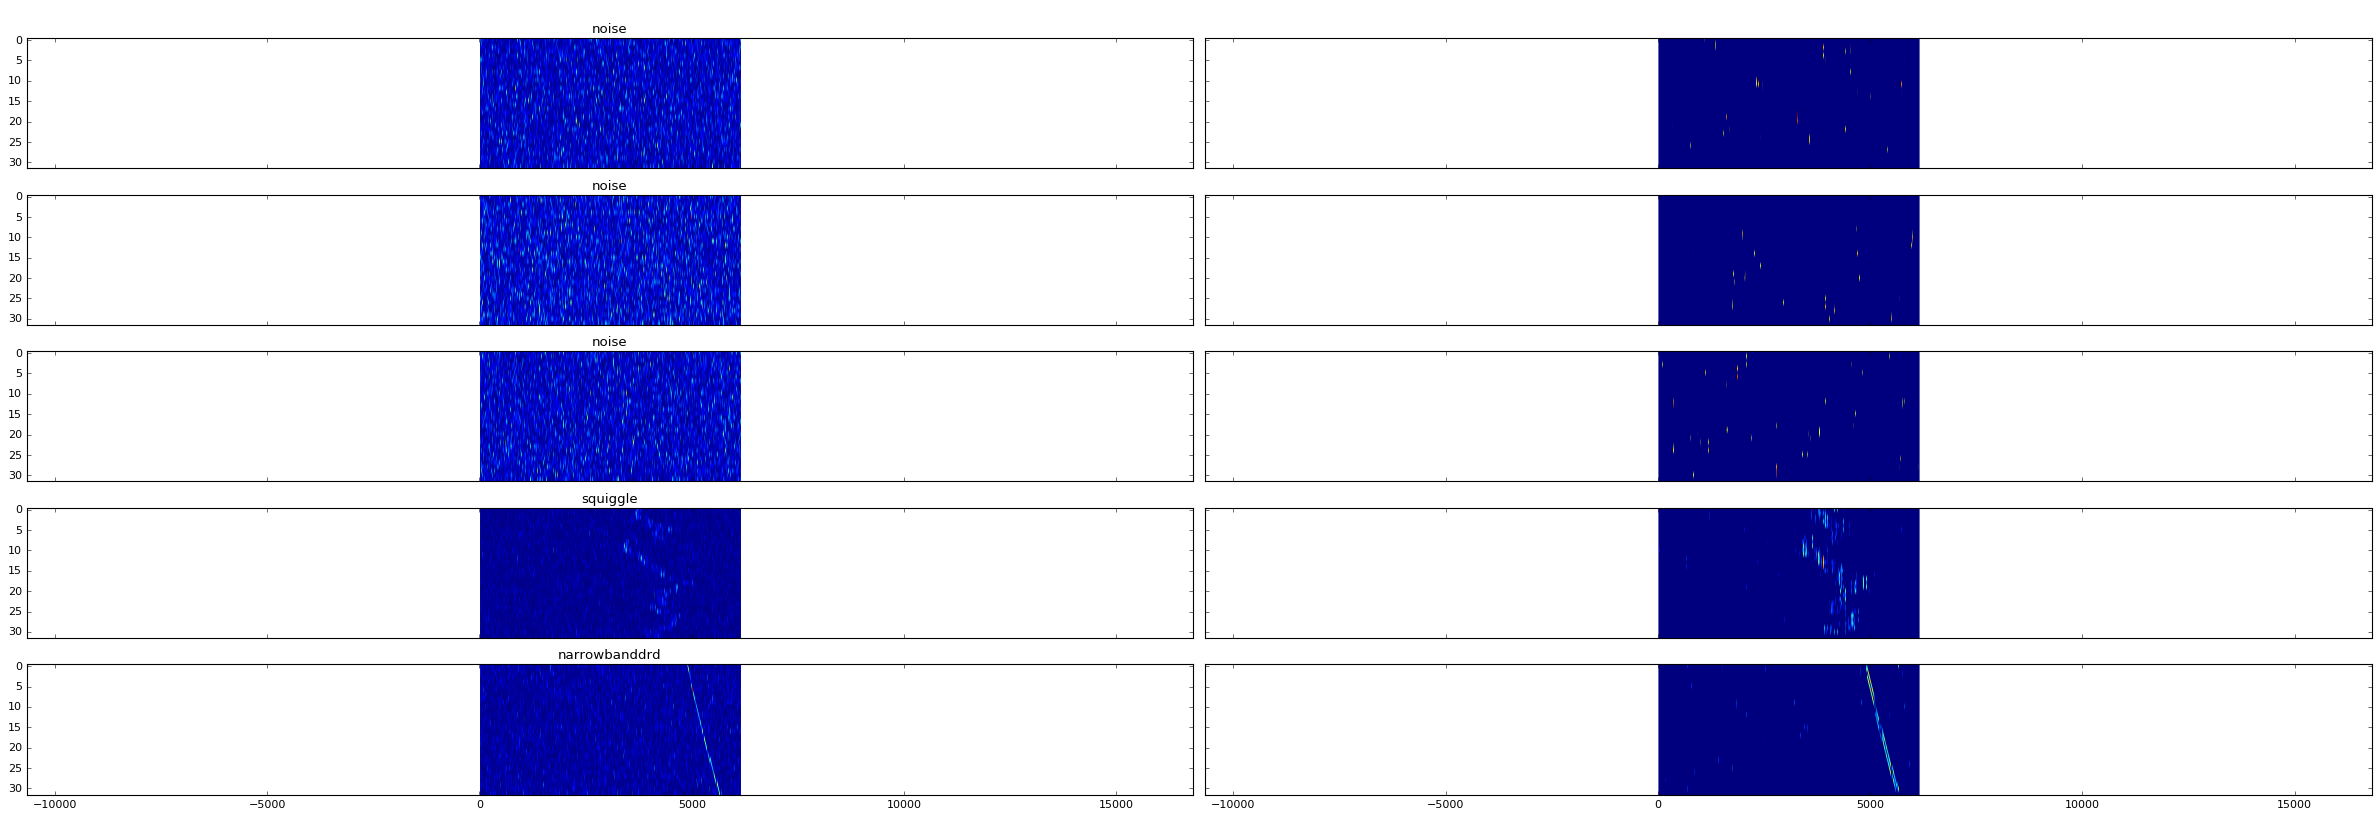

In [28]:
fig, axs = plt.subplots(5,2,figsize=(30, 10), sharex='col', sharey='row')
plt.tight_layout()
plt.subplots_adjust(wspace = 0.01, hspace = 0.2)
for idx, (left, right) in enumerate(axs):
    randIdx = random.randrange(0,4000)
    original = X[randIdx]
    filtered = signal_process(X_copy[randIdx] - average_noise) 
    filtered[filtered < 0] = 0
    left.set_title("\n" + Y[randIdx])
    left.imshow(original,  aspect = 0.5*float(original.shape[1]) / original.shape[0])
    right.imshow(filtered,  aspect = 0.5*float(filtered.shape[1]) / filtered.shape[0])

In [ ]:
firstfile = basic4list[100]
aca = ibmseti.compamp.SimCompamp(zz.open(firstfile).read())
print(aca.header())
spectrogram = aca.get_spectrogram()
spectrogram = spectrogram - noise - np.mean(spectrogram)
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(np.log(spectrogram),  aspect = 0.5*float(spectrogram.shape[1]) / spectrogram.shape[0])